**Main imports**

In [11]:
import math
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda


**Import dataset**

In [2]:
# helper function to make getting another batch of data easier
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

class_names = ['apple','aquarium_fish','baby','bear','beaver','bed','bee','beetle','bicycle','bottle','bowl','boy','bridge','bus','butterfly','camel','can','castle','caterpillar','cattle','chair','chimpanzee','clock','cloud','cockroach','couch','crab','crocodile','cup','dinosaur','dolphin','elephant','flatfish','forest','fox','girl','hamster','house','kangaroo','computer_keyboard','lamp','lawn_mower','leopard','lion','lizard','lobster','man','maple_tree','motorcycle','mountain','mouse','mushroom','oak_tree','orange','orchid','otter','palm_tree','pear','pickup_truck','pine_tree','plain','plate','poppy','porcupine','possum','rabbit','raccoon','ray','road','rocket','rose','sea','seal','shark','shrew','skunk','skyscraper','snail','snake','spider','squirrel','streetcar','sunflower','sweet_pepper','table','tank','telephone','television','tiger','tractor','train','trout','tulip','turtle','wardrobe','whale','willow_tree','wolf','woman','worm',]

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=True, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.CIFAR100('data', train=False, download=True, transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor()
    ])),
    batch_size=64, drop_last=True)

train_iterator = iter(cycle(train_loader))
test_iterator = iter(cycle(test_loader))

print(f'> Size of training dataset {len(train_loader.dataset)}')
print(f'> Size of test dataset {len(test_loader.dataset)}')

100%|██████████| 169001437/169001437 [00:03<00:00, 47725842.81it/s]


Extracting data/cifar-100-python.tar.gz to data
Files already downloaded and verified
> Size of training dataset 50000
> Size of test dataset 10000


**View some of the test dataset**

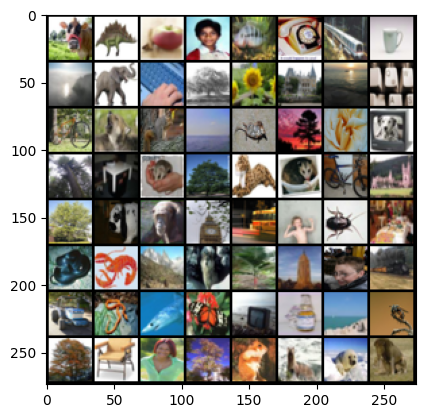

In [3]:
# let's view some of the training data
plt.rcParams['figure.dpi'] = 100
x,t = next(train_iterator)
x,t = x.to(device), t.to(device)
plt.imshow(torchvision.utils.make_grid(x).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**This is an autoencoder pretending to be a generative model**

In [4]:
class Autoencoder(nn.Module):
    def __init__(self, params):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Linear(32*32*params['n_channels'], params['n_latent'])
        self.decoder = nn.Linear(params['n_latent'], 32*32*params['n_channels'])

    def forward(self, x):
        z = self.encoder(x.view(x.size(0), -1))
        z += 0.1*torch.randn_like(z) # crude attempt to make latent space normally distributed so we can sample it
        x = torch.sigmoid(self.decoder(z))
        return x.view(x.size(0), params['n_channels'], 32, 32)

    def sample(self, z): # sample from some prior distribution (it should not depend on x)
        x = torch.sigmoid(self.decoder(z))
        return x.view(x.size(0), params['n_channels'], 32, 32)


# hyperparameters
params = {
    'batch_size': train_loader.batch_size,
    'n_channels': 3,
    'n_latent': 7 # alters number of parameters
}

N = Autoencoder(params).to(device)

print(f'> Number of model parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')
if len(torch.nn.utils.parameters_to_vector(N.parameters())) > 1000000:
    print("> Warning: you have gone over your parameter budget and will have a grade penalty!")

# initialise the optimiser
optimiser = torch.optim.Adam(N.parameters(), lr=0.001)
steps = 0

> Number of model parameters 46087


**Main training loop**

In [6]:
# keep within our optimisation step budget
while (steps < 50000):

    # arrays for metrics
    loss_arr = np.zeros(0)

    # iterate over some of the train dateset
    for i in range(1000):
        x,t = next(train_iterator)
        x,t = x.to(device), t.to(device)

        # train model
        p = N(x)
        loss = F.mse_loss(p, x)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        steps += 1

        loss_arr = np.append(loss_arr, loss.item())

    print('steps {:.2f}, loss: {:.3f}'.format(steps, loss_arr.mean()))

    # sample model and visualise results (ensure your sampling code does not use x)
    N.eval()
    z = torch.randn(params['batch_size'], params['n_latent']).to(device)
    samples = N.sample(z).cpu().detach()
    plt.imshow(torchvision.utils.make_grid(samples).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
    plt.show()
    disp.clear_output(wait=True)
    N.train()

StopIteration: 

**Latent interpolations**

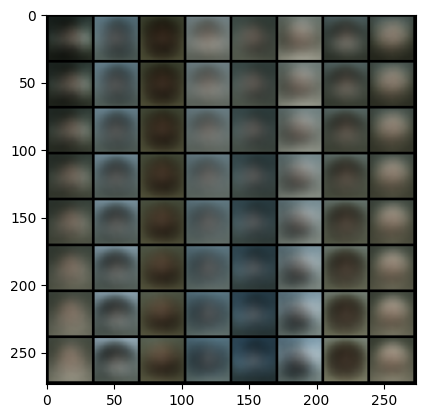

In [7]:
# now show some interpolations (note you do not have to do linear interpolations as shown here, you can do non-linear or gradient-based interpolation if you wish)
col_size = int(np.sqrt(params['batch_size']))

z0 = z[0:col_size].repeat(col_size,1) # z for top row
z1 = z[params['batch_size']-col_size:].repeat(col_size,1) # z for bottom row

t = torch.linspace(0,1,col_size).unsqueeze(1).repeat(1,col_size).view(params['batch_size'],1).to(device)

lerp_z = (1-t)*z0 + t*z1 # linearly interpolate between two points in the latent space
lerp_g = N.sample(lerp_z) # sample the model at the resulting interpolated latents

plt.rcParams['figure.dpi'] = 100
plt.grid(False)
plt.imshow(torchvision.utils.make_grid(lerp_g).cpu().numpy().transpose(1, 2, 0), cmap=plt.cm.binary)
plt.show()

**FID scores**

Evaluate the FID from 10k of your model samples (do not sample more than this) and compare it against the 10k test images. Calculating FID is somewhat involved, so we use a library for it. It can take a few minutes to evaluate. Lower FID scores are better.

In [8]:
%%capture
!pip install clean-fid
import os
from cleanfid import fid
from torchvision.utils import save_image

In [9]:
# define directories
real_images_dir = 'real_images'
generated_images_dir = 'generated_images'
num_samples = 10000 # do not change

# create/clean the directories
def setup_directory(directory):
    if os.path.exists(directory):
        !rm -r {directory} # remove any existing (old) data
    os.makedirs(directory)

setup_directory(real_images_dir)
setup_directory(generated_images_dir)

# generate and save 10k model samples
num_generated = 0
while num_generated < num_samples:

    # sample from your model, you can modify this
    z = torch.randn(params['batch_size'], params['n_latent']).to(device)
    samples_batch = N.sample(z).cpu().detach()

    for image in samples_batch:
        if num_generated >= num_samples:
            break
        save_image(image, os.path.join(generated_images_dir, f"gen_img_{num_generated}.png"))
        num_generated += 1

# save 10k images from the CIFAR-100 test dataset
num_saved_real = 0
while num_saved_real < num_samples:
    real_samples_batch, _ = next(test_iterator)
    for image in real_samples_batch:
        if num_saved_real >= num_samples:
            break
        save_image(image, os.path.join(real_images_dir, f"real_img_{num_saved_real}.png"))
        num_saved_real += 1

In [10]:
# compute FID
score = fid.compute_fid(real_images_dir, generated_images_dir, mode="clean")
print(f"FID score: {score}")

compute FID between two folders


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Found 10000 images in the folder real_images


FID real_images : 100%|██████████| 313/313 [01:09<00:00,  4.49it/s]


Found 10000 images in the folder generated_images


FID generated_images : 100%|██████████| 313/313 [01:08<00:00,  4.55it/s]


FID score: 312.9296090125979
